In [798]:
import matplotlib.pyplot as plt
import pandas as pd
from sqlalchemy import create_engine
import seaborn as sns
import sklearn

#建立與 MySQL 的連結
class mysql_engine():
 def __init__(self,db):
  self.user='root'
  self.passwd=''
  self.host='localhost'
  self.port = '3306'
  self.db_name= db
  self.engine = create_engine('mysql+pymysql://{0}:{1}@{2}:{3}/{4}?charset=utf8'.format(self.user,self.passwd,self.host,self.port,self.db_name))

def get_data(sql,db):
 pg_enine = mysql_engine(db)
 try:
  with pg_enine.engine.connect() as con, con.begin():
   df = pd.read_sql(sql,con) # 獲取資料
  con.close()
 except:
  df = None
 return df

# 以財務數據預測 毛利率

資料前處理

In [799]:
company_factor = get_data("""SELECT *
                            FROM tfb103d_project.datamining_alldata_afetl
                            WHERE stock_report_date < '20212';""",'tfb103d_project')

company_factor

,stock_code,stock_report_date,operating_gross_rate,net_profit_rate,revenue_growth_rate,current_rate,quick_rate,debt_rate,receivables_turnover_rate,cash_reinvest_rate,...,export_usd_value_37071000,export_usd_value_37079090,export_usd_value_37050000306,export_usd_value_848620,export_usd_value_848610,export_usd_value_381800,new_cases_smoothed_USA,new_cases_smoothed_OWID_EUR,new_cases_smoothed_TWN,people_fully_vaccinated_per_hundred_USA
0,2302,20183,38.03,13.35,17.77,154.53,103.70,18.22,3.31,1.74,...,433,15698,18323,61504,3021,107270,0.00,0.00,0.00,0.00
1,2302,20184,40.93,5.22,-0.91,166.92,110.41,16.86,4.35,1.34,...,395,17864,27973,93168,2669,112119,0.00,0.00,0.00,0.00
2,2302,20191,37.03,-3.00,-6.33,171.94,109.89,16.38,0.99,1.51,...,309,16779,17192,72410,4024,96978,0.00,0.00,0.00,0.00
3,2302,20192,32.10,10.26,-2.46,174.72,114.79,16.63,2.00,2.17,...,326,19927,19788,77517,3432,98799,0.00,0.00,0.00,0.00
4,2302,20193,28.78,2.29,-6.54,170.04,116.92,17.45,3.10,4.32,...,339,20499,19911,118643,3547,90681,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1634,8299,20201,30.43,14.75,37.71,326.95,199.20,25.75,1.99,-0.03,...,378,22722,18682,71220,2776,95038,1818.75,5251.16,6.72,0.00
1635,8299,20202,24.76,10.91,10.95,299.48,181.73,27.74,4.28,6.49,...,474,20831,23548,83758,1824,93532,26218.70,22066.62,4.34,0.00
1636,8299,20203,22.61,15.41,-3.71,363.99,240.63,23.66,6.20,5.25,...,362,21623,21166,88039,509,96949,50018.10,27565.47,4.07,0.00
1637,8299,20204,23.05,29.47,-2.52,317.33,230.20,26.09,8.12,11.28,...,338,22734,26507,125111,2209,104276,134753.31,197678.98,7.04,0.29


In [800]:
Roe_rul = get_data("""SELECT roe_rate
                      FROM tfb103d_project.datamining_alldata_afetl
                      WHERE stock_report_date > '20183';""",'tfb103d_project')

In [801]:
# 將數值轉為 1,0 編碼，作為模型的預測目標(應變數)
def encoding(r,th):
    if r >= th:
        return 1
    else:
        return 0

In [802]:
#定義股東權益報酬率 >平均者為表現良好
m2 = Roe_rul['roe_rate'].mean()
Roe_rul['roe_rate1'] = Roe_rul.apply(lambda r : encoding(r['roe_rate'],m2), axis = 1)

In [803]:
X = company_factor[['operating_gross_rate', 'net_profit_rate', 'revenue_growth_rate',
       'current_rate', 'quick_rate', 'cash_reinvest_rate', 'roe_rate',
       'roa_rate', 'foreign_rate_bys', 'avg_import_rate', 'avg_export_rate',
       'export_kgm_weight_37050000306', 'new_cases_smoothed_USA',
       'new_cases_smoothed_TWN']]

X1 = company_factor[['operating_gross_rate', 'net_profit_rate', 'revenue_growth_rate',
       'current_rate', 'quick_rate', 'cash_reinvest_rate', 'roe_rate',
       'roa_rate', 'foreign_rate_bys', 'avg_import_rate', 'avg_export_rate',
       'export_kgm_weight_37050000306', 'new_cases_smoothed_USA',
       'new_cases_smoothed_TWN','new_cases_smoothed_OWID_EUR']]

X2 =  company_factor[['net_profit_rate','operating_gross_rate', 'roe_rate','roa_rate',
                    'current_rate', 'quick_rate',  'debt_rate',  'receivables_turnover_rate', 
                    'cash_reinvest_rate','export_usd_value_381800','new_cases_smoothed_TWN',
                     'import_usd_value_37079090','avg_import_rate']]
             

y = Roe_rul['roe_rate1']

print("X.shape: " ,X.shape)
print("X1.shape: " ,X1.shape)
print("X2.shape: " ,X2.shape)
print("y.shape: " ,y.shape)
print('y.sum():',y.sum())

X.shape:  (1639, 14)
X1.shape:  (1639, 15)
X2.shape:  (1639, 13)
y.shape:  (1639,)
y.sum(): 884


<h3>ROE:  755 筆標記為 0 ； 884 筆為 1
<h3> 基礎準確率為 53.93%

In [804]:
# 輸入數據調成標準值以免各特徵影響不同
# you'll learn why scaling is needed in a later course
# from sklearn.preprocessing import StandardScaler
def mean_norm(df_input):
    return df_input.apply(lambda x: ((x-df_input.mean())/ df_input.std()))

In [805]:
X_scaled = pd.DataFrame()
a, b = X.shape

for i in range(b):
    x_new = mean_norm(X[X.columns[i]])
    X_scaled.insert(i,X.columns[i],x_new)
X_scaled

,operating_gross_rate,net_profit_rate,revenue_growth_rate,current_rate,quick_rate,cash_reinvest_rate,roe_rate,roa_rate,foreign_rate_bys,avg_import_rate,avg_export_rate,export_kgm_weight_37050000306,new_cases_smoothed_USA,new_cases_smoothed_TWN
0,0.310530,0.214147,0.195944,-0.553189,-0.513366,-0.205327,-0.182515,-0.220846,-0.641917,0.561617,0.561617,-0.899728,-0.625915,-0.874567
1,0.420361,0.060193,-0.294623,-0.520781,-0.494960,-0.239816,-0.290044,-0.381183,-0.641917,0.761148,0.761148,-0.798707,-0.625915,-0.874567
2,0.272657,-0.095466,-0.436961,-0.507650,-0.496387,-0.225158,-0.392611,-0.532612,-0.643402,0.738125,0.738125,-0.160078,-0.625915,-0.874567
3,0.085944,0.155633,-0.335329,-0.500379,-0.482945,-0.168251,-0.218909,-0.271322,-0.646868,1.074696,1.074696,-0.185083,-0.625915,-0.874567
4,-0.039793,0.004708,-0.442476,-0.512620,-0.477102,0.017126,-0.331402,-0.440567,-0.646868,1.141572,1.141572,-0.805709,-0.625915,-0.874567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1634,0.022697,0.240658,0.719600,-0.102197,-0.251399,-0.357940,0.681029,0.907451,1.941256,-0.047939,-0.047939,-0.401627,-0.588310,1.381120
1635,-0.192042,0.167942,0.016839,-0.174049,-0.299321,0.204228,0.303849,0.390810,1.671897,-0.291323,-0.291323,-0.176081,-0.083800,0.582231
1636,-0.273468,0.253157,-0.368156,-0.005312,-0.137752,0.097313,0.644634,0.877759,1.394616,-0.775898,-0.775898,0.489554,0.408293,0.491601
1637,-0.256804,0.519405,-0.336905,-0.127359,-0.166362,0.617232,1.585929,2.118886,1.470868,-1.560866,-1.560866,0.711099,2.160336,1.488534


In [806]:
X1_scaled = pd.DataFrame()
a, b = X1.shape

for i in range(b):
    x1_new = mean_norm(X1[X1.columns[i]])
    X1_scaled.insert(i,X1.columns[i],x1_new)
X1_scaled

,operating_gross_rate,net_profit_rate,revenue_growth_rate,current_rate,quick_rate,cash_reinvest_rate,roe_rate,roa_rate,foreign_rate_bys,avg_import_rate,avg_export_rate,export_kgm_weight_37050000306,new_cases_smoothed_USA,new_cases_smoothed_TWN,new_cases_smoothed_OWID_EUR
0,0.310530,0.214147,0.195944,-0.553189,-0.513366,-0.205327,-0.182515,-0.220846,-0.641917,0.561617,0.561617,-0.899728,-0.625915,-0.874567,-0.552314
1,0.420361,0.060193,-0.294623,-0.520781,-0.494960,-0.239816,-0.290044,-0.381183,-0.641917,0.761148,0.761148,-0.798707,-0.625915,-0.874567,-0.552314
2,0.272657,-0.095466,-0.436961,-0.507650,-0.496387,-0.225158,-0.392611,-0.532612,-0.643402,0.738125,0.738125,-0.160078,-0.625915,-0.874567,-0.552314
3,0.085944,0.155633,-0.335329,-0.500379,-0.482945,-0.168251,-0.218909,-0.271322,-0.646868,1.074696,1.074696,-0.185083,-0.625915,-0.874567,-0.552314
4,-0.039793,0.004708,-0.442476,-0.512620,-0.477102,0.017126,-0.331402,-0.440567,-0.646868,1.141572,1.141572,-0.805709,-0.625915,-0.874567,-0.552314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1634,0.022697,0.240658,0.719600,-0.102197,-0.251399,-0.357940,0.681029,0.907451,1.941256,-0.047939,-0.047939,-0.401627,-0.588310,1.381120,-0.478457
1635,-0.192042,0.167942,0.016839,-0.174049,-0.299321,0.204228,0.303849,0.390810,1.671897,-0.291323,-0.291323,-0.176081,-0.083800,0.582231,-0.241950
1636,-0.273468,0.253157,-0.368156,-0.005312,-0.137752,0.097313,0.644634,0.877759,1.394616,-0.775898,-0.775898,0.489554,0.408293,0.491601,-0.164609
1637,-0.256804,0.519405,-0.336905,-0.127359,-0.166362,0.617232,1.585929,2.118886,1.470868,-1.560866,-1.560866,0.711099,2.160336,1.488534,2.228015


In [807]:
X2_scaled = pd.DataFrame()
a, b = X2.shape

for i in range(b):
    x2_new = mean_norm(X2[X2.columns[i]])
    X2_scaled.insert(i,X2.columns[i],x2_new)
X2_scaled

,net_profit_rate,operating_gross_rate,roe_rate,roa_rate,current_rate,quick_rate,debt_rate,receivables_turnover_rate,cash_reinvest_rate,export_usd_value_381800,new_cases_smoothed_TWN,import_usd_value_37079090,avg_import_rate
0,0.214147,0.310530,-0.182515,-0.220846,-0.553189,-0.513366,-0.818028,-0.161824,-0.205327,1.099460,-0.874567,-1.496335,0.561617
1,0.060193,0.420361,-0.290044,-0.381183,-0.520781,-0.494960,-0.898471,-0.064074,-0.239816,1.817215,-0.874567,-0.823357,0.761148
2,-0.095466,0.272657,-0.392611,-0.532612,-0.507650,-0.496387,-0.926863,-0.379883,-0.225158,-0.423973,-0.874567,-1.500584,0.738125
3,0.155633,0.085944,-0.218909,-0.271322,-0.500379,-0.482945,-0.912075,-0.284953,-0.168251,-0.154426,-0.874567,-1.020856,1.074696
4,0.004708,-0.039793,-0.331402,-0.440567,-0.512620,-0.477102,-0.863573,-0.181562,0.017126,-1.356062,-0.874567,-0.224911,1.141572
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1634,0.240658,0.022697,0.681029,0.907451,-0.102197,-0.251399,-0.372635,-0.285892,-0.357940,-0.711134,1.381120,0.332627,-0.047939
1635,0.167942,-0.192042,0.303849,0.390810,-0.174049,-0.299321,-0.254929,-0.070653,0.204228,-0.934054,0.582231,0.987518,-0.291323
1636,0.253157,-0.273468,0.644634,0.877759,-0.005312,-0.137752,-0.496257,0.109809,0.097313,-0.428265,0.491601,0.840153,-0.775898
1637,0.519405,-0.256804,1.585929,2.118886,-0.127359,-0.166362,-0.352525,0.290272,0.617232,0.656285,1.488534,1.239036,-1.560866


In [1178]:
#分割資料為 測試集 與 訓練集
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2,random_state=100)
N, D = X_train.shape
print ("N:", N, "D:", D)

#分割資料為 測試集 與 訓練集
from sklearn.model_selection import train_test_split
X1_train, X1_test, y1_train, y1_test = train_test_split(X1_scaled, y, test_size=0.2,random_state=1)
N1, D1 = X1_train.shape
print ("N:", N1, "D:", D1)

#分割資料為 測試集 與 訓練集
from sklearn.model_selection import train_test_split
X2_train, X2_test, y2_train, y2_test = train_test_split(X2_scaled, y, test_size=0.4,random_state=24)
N2, D2 = X2_train.shape
print ("N:", N2, "D:", D2)

N: 1311 D: 14
N: 1311 D: 15
N: 983 D: 13


<h2> 1-1 以 DNN 類神經網路 實作 - 預測毛利率

In [1179]:
import tensorflow as tf
print(tf.__version__)

2.6.0


In [1180]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout,LeakyReLU
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, f1_score

In [1327]:
# 建立TF模型
model = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(D2,)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.6),
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

#編譯模型
# lr = 0.00005
model.compile(
    optimizer='adam',
#     tf.keras.optimizers.Adam(learning_rate = lr),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [1328]:
model.summary()

Model: "sequential_193"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_579 (Dense)            (None, 128)               1792      
_________________________________________________________________
dropout_383 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_580 (Dense)            (None, 16)                2064      
_________________________________________________________________
dropout_384 (Dropout)        (None, 16)                0         
_________________________________________________________________
dense_581 (Dense)            (None, 1)                 17        
Total params: 3,873
Trainable params: 3,873
Non-trainable params: 0
_________________________________________________________________


In [1329]:
# 訓練模型
r = model.fit(X2_train, y2_train, validation_data=(X2_test, y2_test), epochs=50)

Epoch 1/50
31/31 [==============================] - 0s 4ms/step - loss: 0.6910 - accuracy: 0.5371 - val_loss: 0.6370 - val_accuracy: 0.7622
Epoch 2/50
31/31 [==============================] - 0s 2ms/step - loss: 0.6472 - accuracy: 0.6541 - val_loss: 0.5801 - val_accuracy: 0.8049
Epoch 3/50
31/31 [==============================] - 0s 2ms/step - loss: 0.5799 - accuracy: 0.7365 - val_loss: 0.5228 - val_accuracy: 0.8079
Epoch 4/50
31/31 [==============================] - 0s 2ms/step - loss: 0.5688 - accuracy: 0.7355 - val_loss: 0.4796 - val_accuracy: 0.8140
Epoch 5/50
31/31 [==============================] - 0s 2ms/step - loss: 0.5430 - accuracy: 0.7528 - val_loss: 0.4594 - val_accuracy: 0.8262
Epoch 6/50
31/31 [==============================] - 0s 2ms/step - loss: 0.5073 - accuracy: 0.7833 - val_loss: 0.4423 - val_accuracy: 0.8186
Epoch 7/50
31/31 [==============================] - 0s 2ms/step - loss: 0.5008 - accuracy: 0.7894 - val_loss: 0.4337 - val_accuracy: 0.8171
Epoch 8/50
31/31 [==

In [1344]:
# 評估模型 - evaluate() returns loss and accuracy
import time


print("Train score:", model.evaluate(X2_train, y2_train))


print("Test score:", model.evaluate(X2_test, y2_test))

start = time.time()
pred = model.predict(X2_test)
end = time.time()
print(end - start)
P = np.round(pred).flatten()
print("f1_score:",f1_score(y2_test, P))

31/31 [==============================] - 0s 586us/step - loss: 0.3950 - accuracy: 0.8433
Train score: [0.39503952860832214, 0.8433367013931274]
21/21 [==============================] - 0s 537us/step - loss: 0.3833 - accuracy: 0.8521
Test score: [0.3832553029060364, 0.8521341681480408]
0.04196739196777344
f1_score: 0.8654646324549238


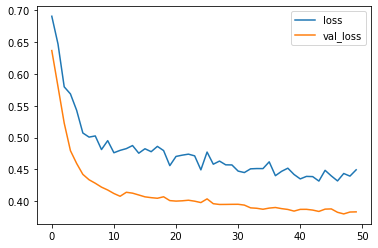

In [1331]:
# 劃出 model.fit() training 和 validating 的 loss
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

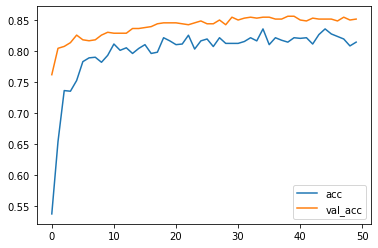

In [1332]:
# 劃出準確性 accuracy 
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

In [1345]:
pred_test = model.predict(X2_test)
pred_test = np.round(pred_test).flatten()
cm = confusion_matrix(y2_test, pred_test)
cm

array([[247,  41],
       [ 56, 312]], dtype=int64)

In [611]:
# model.save('DNN_F3_model_f')

INFO:tensorflow:Assets written to: DNN_F3_model_f\assets


<h1> 1-2 以羅吉斯回歸實作 - 預測毛利率

In [747]:
from sklearn.linear_model import LogisticRegression
log = LogisticRegression()
log.fit(X_train, y_train)

log_pred = log.predict(X_test)
print(log_pred)
print("==============================")
print(log.score(X_train, y_train))
# print(y_test)

[1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 0 1 1
 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 1 1 0
 1 1 0 0 0 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 1
 1 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1
 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1 0 1 1 1
 0 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 1 1 1 0 1
 0 0 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 1]
0.5278413424866514


In [748]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, log_pred)
accuracy

0.5335365853658537

In [749]:
cm = confusion_matrix(y_test, log_pred)
cm

array([[ 21, 116],
       [ 37, 154]], dtype=int64)

<h2> 1-3 以 SVM 實作 - 預測毛利率

In [55]:
from sklearn.svm import SVC
clf = SVC(C = 1e5, kernel = 'linear')
clf.fit(X_train, y_train) 

SVC(C=100000.0, kernel='linear')

In [56]:
pred_clf = clf.predict(X_test)
print(pred_clf)
print("==============================")
print(clf.score(X_train, y_train))

[0 0 0 1 1 0 1 1 1 1 1 1 0 0 1 1 0 0 1 1 1 1 1 0 1 0 1 1 0 1 0 1 1 1 1 1 0
 0 1 0 1 1 1 0 1 1 1 0 1 0 0 1 0 1 1 0 1 1 1 1 1 0 0 1 1 0 0 1 1 0 1 0 1 1
 1 1 1 1 1 1 0 0 1 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 1 0 1 1 0 0 1 0 1 0 0 0 0
 1 1 1 1 1 0 1 1 0 1 1 0 1 0 1 1 0 1 1 1 1 1 1 0 1 1 0 1 0 1 0 0 1 0 1 1 1
 0 1 0 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 0 0 1 0 0 0 0 1 1 0 0 0 1 1 1 1 0 1 1
 0 0 1 1 1 1 0 0 1 0 1 1 1 0 1 0 1 0 1 0 0 0 1 1 0 1 1 1 0 0 0 1 0 1 0 1 0
 0 0 0 1 0 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1 0 0 0 0 1 1 1 0 0 1 1 1 0 0 1 1 0
 1 0 1 1 1 0 0 0 1 1 0 0 0 1 1 1 1 1 0 1 1 0 1 1 0 1 1 0 0 0 1 1 1 1 0 1 0
 0 1 1 0 1 1 0 0 1 0 1 0 0 1 0 0 1 1 1 1 1 1 0 0 1 0 1 0 0 1 1 1]
0.8161708619374524


In [57]:
accuracy_SVM = accuracy_score(y_test, pred_clf)
accuracy_SVM

0.7957317073170732

<h1>1.4 以 RandomForestClassifier 實作 毛利率預測

In [58]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
forest=RandomForestClassifier(n_estimators=100)


#Train the model using the training sets y_pred=clf.predict(X_test)
forest.fit(X_train, y_train)
print(forest.score(X_train, y_train))

1.0


In [59]:
from sklearn.metrics import accuracy_score
forest_pred=forest.predict(X_test)
print("Accuracy:",accuracy_score(y_test, forest_pred))

Accuracy: 0.8170731707317073


In [60]:
pred_test = np.round(forest_pred).flatten()
cm = confusion_matrix(y_test, pred_test)
cm

array([[115,  33],
       [ 27, 153]], dtype=int64)

<h1> 1.5 以 naive_bayes 實作 毛利率預測

In [61]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train, y_train)
print(nb.score(X_train, y_train))

0.7200610221205187


In [62]:
nb_pred = nb.predict(X_test)
print("Accuracy:",accuracy_score(y_test, nb_pred))

Accuracy: 0.7134146341463414


In [63]:
pred_test = np.round(nb_pred).flatten()
cm = confusion_matrix(y_test, pred_test)
cm

array([[ 62,  86],
       [  8, 172]], dtype=int64)

<h1> 1.6 以 KNN 實作 毛利率預測

In [64]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
print(knn.score(X_train, y_train))

0.8489702517162472


In [65]:
knn_pred = knn.predict(X_test)
print("Accuracy:",accuracy_score(y_test, knn_pred))

Accuracy: 0.7682926829268293


In [66]:
pred_test = np.round(knn_pred).flatten()
cm = confusion_matrix(y_test, pred_test)
cm

array([[101,  47],
       [ 29, 151]], dtype=int64)

<h2>初步測試預測"毛利率"結果:</h2>
<h4>1-1 DNN: 
    <h4>測試資料集準確度 0.8779; 訓練資料準確度 0.7836</h4>
<h4>1-2 Logistic:
    <h4>測試資料集準確度 0.7204; 訓練資料準確度 0.6648</h4>
<h4>1-3 SVM: 
    <h4>測試資料集準確度 0.5316; 訓練資料準確度 0.5068</h4>
<h4>1-4 RandomForestClassifier: 
    <h4>測試資料集準確度 1.0000; 訓練資料準確度 0.8366</h4>
<h4>1-5 naive_bayes: 
    <h4>測試資料集準確度 0.5275; 訓練資料準確度 0.4930</h4>
<h4>1-6 KNN: 
    <h4>測試資料集準確度 0.6944; 訓練資料準確度 0.4676</h4>

<h3>目前"毛利率"表現最佳者為 RandomForestClassifier，DNN 其次

<h3>_____________________分隔_______________________